In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

Сначала нужно залить файлы в хранилище CoLab

In [2]:
df_2 = pd.read_csv('Просьбы_жителей_Лемматизация.csv')
df_2.head(5)

,Unnamed: 0,Unnamed: 0.1,Адрес обращения,Дом,Дата,текст обращения,ids,listTextAppealLem
0,0,0,улица Советская,50А,2021-06-05 22:08:11.225,Тротуар возле рощи,10000,"['тротуар', 'возле', 'роща']"
1,1,1,улица Кукшумская,9,2021-06-11 20:56:03.802,прошу асфальтировать тротуар по улице Кукшумск...,10001,"['просить', 'асфальтировать', 'тротуар', 'улиц..."
2,2,2,улица Кукшумская,9,2021-06-11 21:00:13.376,прошу асфальтировать тротуар по улице Кукшумск...,10002,"['просить', 'асфальтировать', 'тротуар', 'улиц..."
3,3,3,улица Социалистическая,19,2021-06-12 13:08:16.467,"Бегают тараканы по всему подъезду, необходимо ...",10003,"['бегать', 'таракан', 'весь', 'подъезд', 'необ..."
4,4,4,улица Ахазова,7,2021-06-15 17:10:23.232,Мы жильцы дома №7 живем с 1978 и капитального ...,10004,"['жилец', 'дом', '№', '7', 'жить', '1978', 'ка..."


## Подгружаем эмбеддинги navec - компактные представления русских слов

In [3]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
!pip install navec

--2021-10-31 05:04:58--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  14.9MB/s    in 4.6s    

2021-10-31 05:05:04 (11.0 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [4]:
from navec import Navec

path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
embeddings = Navec.load(path)
embeddings = embeddings.as_gensim

# Создаем векторные описания

In [5]:
def determ_mean_vec(embeddings, list_term):
    """
        list_term: список слов (леммы предложения)
        embeddings: наши векторные представление     
        return: среднее векторное представление списка слов
    """

    mean_vec = np.zeros(embeddings.vector_size)

    i = 0
    for term in list_term:
        try:
            mean_vec += embeddings[term]
            i += 1
        except:
            pass

    if i == 0:
        return np.zeros(embeddings.vector_size), "Нет данных"
    else:
        return (mean_vec / i).reshape(1, -1), "Есть данные"

In [6]:
'''Список векторов'''
request_vec = []
'''Список того, не пустой ли вектор'''
request_exist = []
for request in tqdm(df_2['listTextAppealLem']):
    mean_vec, exist = determ_mean_vec(embeddings, request)
    request_vec.append(mean_vec)
    request_exist.append(exist)

100%|██████████| 8557/8557 [00:01<00:00, 4737.01it/s]


In [7]:
df_2['request_vec'] = request_vec
df_2['request_exist'] = request_exist
'''Оставляем только ту часть датафрейма, где есть данные'''
df_2 = df_2[df_2['request_exist'] == 'Есть данные']
df_2.reset_index(inplace = True)
df_2.head(5)

,index,Unnamed: 0,Unnamed: 0.1,Адрес обращения,Дом,Дата,текст обращения,ids,listTextAppealLem,request_vec,request_exist
0,0,0,0,улица Советская,50А,2021-06-05 22:08:11.225,Тротуар возле рощи,10000,"['тротуар', 'возле', 'роща']","[[-0.09077115636318922, -0.18184331260272302, ...",Есть данные
1,1,1,1,улица Кукшумская,9,2021-06-11 20:56:03.802,прошу асфальтировать тротуар по улице Кукшумск...,10001,"['просить', 'асфальтировать', 'тротуар', 'улиц...","[[-0.09124771497668104, -0.3014607395818259, -...",Есть данные
2,2,2,2,улица Кукшумская,9,2021-06-11 21:00:13.376,прошу асфальтировать тротуар по улице Кукшумск...,10002,"['просить', 'асфальтировать', 'тротуар', 'улиц...","[[-0.09124771497668104, -0.3014607395818259, -...",Есть данные
3,3,3,3,улица Социалистическая,19,2021-06-12 13:08:16.467,"Бегают тараканы по всему подъезду, необходимо ...",10003,"['бегать', 'таракан', 'весь', 'подъезд', 'необ...","[[-0.0028557123705035166, -0.15949166690679414...",Есть данные
4,4,4,4,улица Ахазова,7,2021-06-15 17:10:23.232,Мы жильцы дома №7 живем с 1978 и капитального ...,10004,"['жилец', 'дом', '№', '7', 'жить', '1978', 'ка...","[[-0.01059560155839596, -0.2097125289604538, 0...",Есть данные


In [8]:
'''Формируем обучающую выборку из векторных представлений предложений'''
data = np.vstack([i for i in df_2['request_vec']])

# Выбор модели

In [9]:
from sklearn.cluster import KMeans

def k_means_fit(data, n_clust = 7):

    model = KMeans(n_clusters = n_clust, max_iter = 1000, init = 'k-means++', random_state = 1) 

    model.fit(data)

    labels = model.labels_

    return model, labels

Выбор числа кластеров методом локтя

In [10]:
# inert = []
# for n_clust in tqdm(range(1, 22)):
#     model, labels = k_means_fit(data,  n_clust = n_clust )
#     inert.append(model.inertia_)

# plt.figure(figsize = (10,8))
# plt.plot(range(1, 22), inert)

Оптимальным исходя из графика можно считать 5 - 7 кластеров

array([4, 1, 1, ..., 4, 0, 0], dtype=int32)

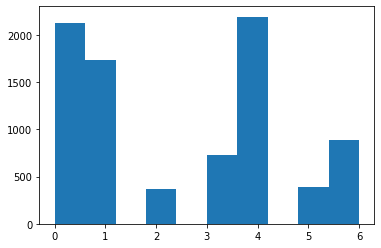

In [11]:
model, labels = k_means_fit(data,  n_clust = 7 )
plt.hist(labels)
labels

In [12]:
df_2['labels'] = labels

In [13]:
dict_len = {}
for i in set(labels):
    dict_len[i] = labels[labels == i].shape[0]
dict_len

{0: 2126, 1: 1738, 2: 368, 3: 724, 4: 2191, 5: 394, 6: 890}

Смотрим, что получилось в кластерах

In [14]:
pd.set_option('display.max_rows', None)
df_2[df_2['labels'] == 2].head(200)

,index,Unnamed: 0,Unnamed: 0.1,Адрес обращения,Дом,Дата,текст обращения,ids,listTextAppealLem,request_vec,request_exist,labels
17,17,17,17,улица Чернышевского,27,2021-06-07 23:31:02.995,"Мало школ, банкоматов",10017,"['мало', 'школа', 'банкомат']","[[-0.10525707790956777, -0.30005446125698443, ...",Есть данные,2
40,40,40,40,проспект Тракторостроителей,45,2021-06-10 03:44:26.715,Парковка,10040,['парковка'],"[[-0.2111837211996317, -0.33091617561876774, -...",Есть данные,2
98,102,102,102,проспект Тракторостроителей,5,2021-06-07 00:20:01.278,"Шум возле кафе ""Парковка""",10102,"['шум', 'возле', 'кафе', ' ""', 'парковка']","[[-0.09700385257601737, -0.2855864757904783, -...",Есть данные,2
139,143,143,143,улица Энтузиастов,23,2021-06-06 21:45:25.264,лавочки во дворе,10143,"['лавочка', 'двор']","[[-0.03565807640552521, -0.24997718433256855, ...",Есть данные,2
142,146,146,146,улица Чернышевского,23 корп. 1,2021-06-07 23:39:10.807,"Мало школ, банкоматов",10146,"['мало', 'школа', 'банкомат']","[[-0.10525707790956777, -0.30005446125698443, ...",Есть данные,2
162,169,169,169,улица Альгешевская,25 корп. А,2021-06-10 11:59:20.137,Обустроить Обиковскую рощу.,10169,"['обустраивать', 'обиковский', 'роща']","[[-0.11379833476474652, -0.2958984781916325, -...",Есть данные,2
185,192,192,192,улица П.В.Дементьева,3 корп. 1,2021-06-08 22:39:44.384,"парковку бы, дет.площадку, школу, парк",10192,"['парковка', 'дет', 'площадка', 'школа', 'парк']","[[-0.13394156590636289, -0.23199653036759368, ...",Есть данные,2
197,204,204,204,улица Чернышевского,27,2021-06-08 10:17:47.162,"парк, банкомат",10204,"['парк', 'банкомат']","[[-0.14560010998199382, -0.3471931877235572, 0...",Есть данные,2
200,207,207,207,улица Короленко,22,2021-06-05 23:57:16.757,дорогу вдоль гаражей\nдет.поликлинику\nкаток,10207,"['дорога', 'вдоль', 'гараж', 'дет', 'поликлини...","[[-0.09360275960394314, -0.22601062590256332, ...",Есть данные,2
202,209,209,209,улица Чернышевского,14,2021-06-07 10:03:39.649,"Детская площадка, парковка",10209,"['детский', 'площадка', 'парковка']","[[-0.13341677399433177, -0.29721813399911573, ...",Есть данные,2


In [15]:
dict_labels = {0:'Общее благоустройство',
               1:'Общее благоустройство',
               2:'Парковка/школа',
               3:'Капитальный ремонт в доме',
               4:'Необходимость дороги/тротуара',
               5:'Ремонт дороги',
               6:'Детская площадка',
               }

named_labels = [dict_labels[i] for i in labels ]

In [16]:
df_2['named_labels'] = named_labels

Категории "школа" и "площадка" в силу свойств данных оказываются неразделимы, поэтому разделим их по ключевым словам. Категория "школа" будет в приоритете, если они встречаются вместе

In [17]:
for counter, name in enumerate(named_labels):
    if ('парковка' in df_2['listTextAppealLem'][counter]) & (df_2['named_labels'][counter] =='Парковка/школа'):
        named_labels[counter] = 'Парковка'

for counter, name in enumerate(named_labels):
    if ('школа' in df_2['listTextAppealLem'][counter]) and (df_2['named_labels'][counter] =='Парковка/школа') and ('дорога' not in df_2['listTextAppealLem'][counter]):
        named_labels[counter] = 'Школа'    

'''Удаляем старую категорию'''
for counter, name in enumerate(named_labels):
    if name == 'Парковка/школа':
        named_labels[counter] = 'Общее благоустройство'

df_2['named_labels'] = named_labels   

Замена названий на английские

In [18]:
en_dict_labels = {'Общее благоустройство':'General improvement',
               'Капитальный ремонт в доме':'Major overhaul',
               'Необходимость дороги/тротуара':'Need for a road',
               'Ремонт дороги':'Need for a road',
               'Детская площадка':'Playground',
               'Парковка':'Parking',
               'Школа':'school'
               }

en_labels = [en_dict_labels[i] for i in named_labels]

In [19]:
df_2['named_labels'] = en_labels  

In [20]:
df_2['named_labels'].value_counts()

General improvement    4003
Need for a road        2585
Playground              890
Major overhaul          724
Parking                 137
school                   92
Name: named_labels, dtype: int64

In [21]:
df_2.head(5)

,index,Unnamed: 0,Unnamed: 0.1,Адрес обращения,Дом,Дата,текст обращения,ids,listTextAppealLem,request_vec,request_exist,labels,named_labels
0,0,0,0,улица Советская,50А,2021-06-05 22:08:11.225,Тротуар возле рощи,10000,"['тротуар', 'возле', 'роща']","[[-0.09077115636318922, -0.18184331260272302, ...",Есть данные,4,Need for a road
1,1,1,1,улица Кукшумская,9,2021-06-11 20:56:03.802,прошу асфальтировать тротуар по улице Кукшумск...,10001,"['просить', 'асфальтировать', 'тротуар', 'улиц...","[[-0.09124771497668104, -0.3014607395818259, -...",Есть данные,1,General improvement
2,2,2,2,улица Кукшумская,9,2021-06-11 21:00:13.376,прошу асфальтировать тротуар по улице Кукшумск...,10002,"['просить', 'асфальтировать', 'тротуар', 'улиц...","[[-0.09124771497668104, -0.3014607395818259, -...",Есть данные,1,General improvement
3,3,3,3,улица Социалистическая,19,2021-06-12 13:08:16.467,"Бегают тараканы по всему подъезду, необходимо ...",10003,"['бегать', 'таракан', 'весь', 'подъезд', 'необ...","[[-0.0028557123705035166, -0.15949166690679414...",Есть данные,0,General improvement
4,4,4,4,улица Ахазова,7,2021-06-15 17:10:23.232,Мы жильцы дома №7 живем с 1978 и капитального ...,10004,"['жилец', 'дом', '№', '7', 'жить', '1978', 'ка...","[[-0.01059560155839596, -0.2097125289604538, 0...",Есть данные,0,General improvement


In [22]:
df_2.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1','request_vec', 'request_exist', 'labels'], axis=1, inplace=True)

In [23]:
df_2.head(4)

,index,Адрес обращения,Дом,Дата,текст обращения,ids,listTextAppealLem,named_labels
0,0,улица Советская,50А,2021-06-05 22:08:11.225,Тротуар возле рощи,10000,"['тротуар', 'возле', 'роща']",Need for a road
1,1,улица Кукшумская,9,2021-06-11 20:56:03.802,прошу асфальтировать тротуар по улице Кукшумск...,10001,"['просить', 'асфальтировать', 'тротуар', 'улиц...",General improvement
2,2,улица Кукшумская,9,2021-06-11 21:00:13.376,прошу асфальтировать тротуар по улице Кукшумск...,10002,"['просить', 'асфальтировать', 'тротуар', 'улиц...",General improvement
3,3,улица Социалистическая,19,2021-06-12 13:08:16.467,"Бегают тараканы по всему подъезду, необходимо ...",10003,"['бегать', 'таракан', 'весь', 'подъезд', 'необ...",General improvement


In [24]:
name = 'Вторая категоризация.csv'
df_2.to_csv(name, index=False, encoding='utf-8')

In [25]:
df_check = pd.read_csv(name)
df_check.head(10)

,index,Адрес обращения,Дом,Дата,текст обращения,ids,listTextAppealLem,named_labels
0,0,улица Советская,50А,2021-06-05 22:08:11.225,Тротуар возле рощи,10000,"['тротуар', 'возле', 'роща']",Need for a road
1,1,улица Кукшумская,9,2021-06-11 20:56:03.802,прошу асфальтировать тротуар по улице Кукшумск...,10001,"['просить', 'асфальтировать', 'тротуар', 'улиц...",General improvement
2,2,улица Кукшумская,9,2021-06-11 21:00:13.376,прошу асфальтировать тротуар по улице Кукшумск...,10002,"['просить', 'асфальтировать', 'тротуар', 'улиц...",General improvement
3,3,улица Социалистическая,19,2021-06-12 13:08:16.467,"Бегают тараканы по всему подъезду, необходимо ...",10003,"['бегать', 'таракан', 'весь', 'подъезд', 'необ...",General improvement
4,4,улица Ахазова,7,2021-06-15 17:10:23.232,Мы жильцы дома №7 живем с 1978 и капитального ...,10004,"['жилец', 'дом', '№', '7', 'жить', '1978', 'ка...",General improvement
5,5,улица Кадыкова,18 корп. 1,2021-06-05 17:12:17.676,Нужны дополнительные парковочные места..,10005,"['нужный', 'дополнительный', 'парковочный', 'м...",Major overhaul
6,6,улица Ольдеевская,74,2021-06-12 22:02:42.455,Нужна нам всем жителям деревни Дорога!!,10006,"['нужный', 'весь', 'житель', 'деревня', 'дорог...",General improvement
7,7,проспект Ленина,25,2021-06-07 18:55:59.315,Навести порядок и обустроить место для ТБО.,10007,"['навещать', 'порядок', 'обустраивать', 'место...",General improvement
8,8,проспект Мира,ё,2021-06-09 09:54:16.566,сделать дорогу,10008,"['сделать', 'дорога']",Need for a road
9,9,переулок Ягодный,7,2021-06-07 22:23:15.328,"поменять в доме провода, щиток опасный.нужен к...",10009,"['поменять', 'дом', 'провод', 'щиток', 'опасны...",Major overhaul
